In [56]:
import os
import json

# Define the root directory where folders are located
root_directory = "elements"  # Change this to your actual root directory

# Initialize a list to store results
results = []

# Iterate through each folder in the root directory
for folder_name in os.listdir(root_directory):
    folder_path = os.path.join(root_directory, folder_name)
    
    if os.path.isdir(folder_path):
        code_content = None
        index_content = None
        
        # Read Code.tsx file
        code_file_path = os.path.join(folder_path, "Code.tsx")
        if os.path.exists(code_file_path):
            with open(code_file_path, "r", encoding="utf-8") as file:
                code_content = file.read()
        
        # Read index.txt file
        index_file_path = os.path.join(folder_path, "index.txt")
        if os.path.exists(index_file_path):
            with open(index_file_path, "r", encoding="utf-8") as file:
                index_content = file.read()

        # Read description.txt file
        description_file_path = os.path.join(folder_path, "description.txt")
        if os.path.exists(description_file_path):
            with open(description_file_path, "r", encoding="utf-8") as file:
                description_content = file.read()
        
        # Append result to the list
        results.append({
            "elementType": folder_name,
            "code": code_content,
            "meta": index_content,
            "description": description_content
        })

# Save results to a JSON file
output_file = "output.json"
with open(output_file, "w", encoding="utf-8") as json_file:
    json.dump(results, json_file, ensure_ascii=False, indent=2)

print(f"JSON file '{output_file}' created successfully.")

JSON file 'output.json' created successfully.


In [57]:
import lancedb
import langchain
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import LanceDB
from langchain.chat_models import ChatOpenAI
from langgraph.graph import StateGraph, END, START
from langchain.schema import SystemMessage, HumanMessage
from typing import List, Dict
import logging


In [58]:
from langchain_openai import ChatOpenAI
import os
from pydantic import BaseModel, Field
from langchain.chat_models import ChatOllama

logging.basicConfig(format="%(asctime)s - %(message)s", level=logging.INFO)

llm = ChatOpenAI(
    model= "gpt-4o",
    api_key= os.environ["GITHUB_API_KEY"],
    base_url= "https://models.inference.ai.azure.com",
)

TOGETHER_AI_BASE_URL = "https://api.together.xyz/v1"
llama3_3_chat = ChatOpenAI(
    model="meta-llama/Llama-3.3-70B-Instruct-Turbo",
    base_url=TOGETHER_AI_BASE_URL,
    api_key=os.environ["TOGETHERAI_API_KEY"]
)

ollama_model = ChatOllama(
    model="llama3.2:latest", 
    base_url="http://localhost:11434" 
)

class StateDefinition(BaseModel):
    name: str = Field(..., title="State Name")
    defaultValue: str = Field(..., title="Default Value")

class TaskDefinition(BaseModel):
    title: str = Field(..., title="Task Title")
    jsx: str | None  = Field(..., title="jsx code of Task")
    elementTypes : List[str] | None = Field(..., title="Element Types used in Task")

# Define Agent State
class AgentState(BaseModel):
    query: str
    is_relevant: bool = True
    tasks: List[TaskDefinition] = []
    stateList: List[StateDefinition] = []
    finalJsx: str = ""

In [59]:
from lancedb.embeddings import get_registry
embedding_model = get_registry().get("sentence-transformers").create(name="BAAI/bge-small-en-v1.5")

#You should put HF_TOKEN in the Notebook enviroment variables
from lancedb.pydantic import LanceModel, Vector

# Connect to LanceDB (Vector Database for JSX Retrieval)
db = lancedb.connect(".lancedb")  
# vector_store = LanceDB(db, OpenAIEmbeddings())

data = []
# read data from output.json file
with open("output.json", "r", encoding="utf-8") as file:
    data = json.load(file)

class ChunksOfData(LanceModel):
    elementType: str = ""
    code: str | None = None  # Allow null values
    meta: str = ""
    description: str = embedding_model.SourceField()
    vector: Vector(embedding_model.ndims()) = embedding_model.VectorField()


tbl = db.create_table(
    "react_elements",
    data= data,
    schema=ChunksOfData,
    exist_ok=True,
    mode="overwrite"
)

Batches: 100%|██████████| 2/2 [00:03<00:00,  1.52s/it]


In [60]:
tbl = db.open_table("react_elements")
query = "stepper"

res= tbl.search(query).limit(5).to_pandas()
res

Batches: 100%|██████████| 1/1 [00:00<00:00, 21.74it/s]


,elementType,code,meta,description,vector,_distance
0,STEPER_CONTAINER,"import React, { HTMLAttributes, useEffect } fr...","{\n elementType: ""KdStepRoot"",\n children: [...",The StepperContainer component is a customizab...,"[-0.08120559, -0.01681594, 0.01594159, 0.08188...",0.498129
1,STEPER_ELEMENT,"import React from ""react"";\nimport Stepper, { ...","{\n elementType: ""KdStepContent"",\n children...",The StepperElement component is a customizable...,"[-0.0795035, -0.003919346, 0.03310318, 0.07101...",0.526760
2,DIVIDER,"import { Divider, DividerProps } from ""@mui/ma...","{\n elementType: ""KdpaDivider"",\n children: ...",The Divider component is a customizable divide...,"[-0.059442475, 0.007873253, 0.052195694, 0.037...",0.847340
3,LAYOUT_ROW,"import React from ""react"";\nimport Grid, { Gri...","{\n elementType: ""KdpaGrid"",\n children: [],...",The LayoutRow component is a simple customizab...,"[-0.050765403, -0.0011405194, 0.047058355, -0....",0.854789
4,TIME_PICKER,"import { useMemo } from ""react"";\nimport momen...","{\n elementType: ""KdFormField"",\n children: ...",The TimePicker component is a customizable tim...,"[-0.10697585, -0.004894975, 0.038828358, -0.00...",0.892273


In [61]:
from pydantic import BaseModel, Field

class RelevantUserQuery(BaseModel):
    is_relevant : bool = Field(description="boolean for relevance or not")

# **Relevance Check Node**
def check_relevance(state: AgentState):
    prompt = f"Is the following request related to front-end UI component generation? \n\nQuery: {state.query}"
    
    structured_model = llm.with_structured_output(RelevantUserQuery)
    
    response = structured_model.invoke([SystemMessage(content="You determine if a query is relevant to UI development."),
                           HumanMessage(content=prompt)])
        
    logging.info(f"Relevance Check Response: {response.is_relevant}")
    
    state.is_relevant = response.is_relevant
    return state

In [62]:
from pydantic import BaseModel, Field

class TaskList(BaseModel):
    tasks : List[str] = Field(description="list of tasks")

# **Task Processing Node**
def process_query(state: AgentState):
    prompt = f"{state.query}"

    structured_model = llm.with_structured_output(TaskList)
    response = structured_model.invoke([SystemMessage(content="""You analyze UI queries and generate structured tasks.
                                                      you are assistant for craete jsx code but in mullti step process.
                                                      you should generate each of tag element with style and attributes recursively.

                                                      for done this recursively you should the user query divide to some task and do it step by step.
                                                      now create sub task of user query for generate jsx code for each tag element recursively.
                                                      """),
                           HumanMessage(content=prompt)])
    
    logging.info(f"Task Processing Response: {response.tasks}\n ======================================= \n")
    state.tasks = [ {"title": task, "jsx": "", "elementTypes": []} for task in response.tasks]
    return state

In [63]:
from pydantic import BaseModel, Field

class JsxTask(BaseModel):
    jsx : str = Field(description=" string of jsx code")
    elementTypes : List[str] = Field(description="list of element types required in the jsx code")

# **Generate JSX Using LLM**
def generate_code(state: AgentState):
    for task in state.tasks:
        context = ''.join([f"elementType({c['elementType']}): {c['description']}\n\n" for c in data])

        prompt = f"""
        Task: {task.title}\n\n Context: {context}\n\n
        """
        structured_model = llm.with_structured_output(JsxTask)
        
        response = structured_model.invoke([SystemMessage(content="""You refine JSX to match UI tasks. and list of element types used in JSX code.
                                                          I do not want react component and only want JSX code without any event 
                                                            handler or any other react component.
                                                          but can use style and valid attributes.
                                                          but my element is specific and can not use any element.
                                                          in context exist description of my element and refine JSX only base
                                                          element in Context.
                                                          """),
                               HumanMessage(content=prompt)])
        
        logging.info("Generated JSX for task '{}': {}".format(task.title, response.jsx))
        newTask = TaskDefinition(title=task.title, jsx=response.jsx, elementTypes=response.elementTypes)
        
        state.tasks[state.tasks.index(task)] = newTask
    
    return state

In [64]:
class FinalResult(BaseModel):
    jsx : str = Field(description="string of jsx code")
    stateDefinitionList: List[StateDefinition] = Field(description="list of state definition")

# **Merge All JSX into a Final Component**
def merge_code(state: AgentState):
    context = ''.join([f"{c['elementType']}: {c['description']}\n\n" for c in data])

    tasksJsx = [task.jsx for task in state.tasks]

    prompt = f"""the user query is: {state.query}.\n\n 
    at the first we break the user query to sub tasks and recusive generate jsx code for each of them, this is of sub task and
    
    generataed jsx: {tasksJsx}.
    context: {context}.
    
    """
    
    structured_model = llm.with_structured_output(FinalResult)
    response = structured_model.invoke([SystemMessage(content="""You combine JSX elements into a structured jsx.
                                                      I want base on sub generated code and task, you generate complete jsx of user query.
                                                      I do not want react component and only want JSX code without any event 
                                                            handler or any other react component.
                                                      but can use style and valid attributes.
                                                      but my element is specific and can not use any element.
                                                          in context exist description of my element and refine JSX only base
                                                          element in Context and not use element without context element.
    note: response that you generate must be only based on sub generated code and task.
    if this jsx need to define state you should define it in stateList. and can be used in jsx code
                                                      """),
                           HumanMessage(content=prompt)])
    state.stateList = state.stateList + (response.stateDefinitionList if response.stateDefinitionList else [])
    state.finalJsx = response.jsx
    
    logging.info("Final Generated React jsx :\n {}".format(response.jsx))
    return state

In [65]:
from typing import Literal

def decide_mood(state) -> Literal["process_query", END]:
    # Often, we will use state to decide on the next node to visit
    if state.is_relevant == True:
        return "process_query"
    
    else:
        return END

In [66]:
# **Define Graph Workflow**
workflow = StateGraph(AgentState)

# Add Nodes
workflow.add_node("check_relevance", check_relevance)
workflow.add_node("process_query", process_query)
workflow.add_node("generate_code", generate_code)
workflow.add_node("merge_code", merge_code)

workflow.add_edge(START, "check_relevance")

# **Conditional Edge:**
workflow.add_conditional_edges(
    "check_relevance",  # From
    decide_mood
)

# Normal Edges
workflow.add_edge("process_query", "generate_code")
workflow.add_edge("generate_code", "merge_code")
workflow.add_edge("merge_code", END)

# Compile and Run
graph = workflow.compile()

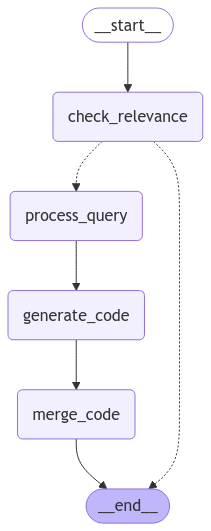

In [67]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [68]:
initial_stateee = AgentState(query="""I want a beautifuly header:
                             in the right a image box have logo and title of website.
                             in the left many item link that each of them have a icon and text.
                             like : link to shoppage, link to about us page, link to contact us page.
                             and at the end of left side a button for login.
                             """)

graph.invoke(initial_stateee)

2025-02-18 20:56:33,999 - HTTP Request: POST https://models.inference.ai.azure.com/chat/completions "HTTP/1.1 200 OK"
2025-02-18 20:56:34,075 - Relevance Check Response: True
2025-02-18 20:56:35,877 - HTTP Request: POST https://models.inference.ai.azure.com/chat/completions "HTTP/1.1 200 OK"
2025-02-18 20:56:35,883 - Task Processing Response: ['Create the outer container for the header with proper styling.', 'Create the right section of the header containing an image box for the logo and the title of the website.', 'Create the left section of the header containing multiple links, each with an icon and text.', 'Add a button at the end of the left section for login.']

2025-02-18 20:56:38,517 - HTTP Request: POST https://models.inference.ai.azure.com/chat/completions "HTTP/1.1 200 OK"
2025-02-18 20:56:38,523 - Generated JSX for task 'Create the outer container for the header with proper styling.': <KdpaGrid style={{ display: 'flex', alignItems: 'center', justifyContent: 'space-between', 

{'query': 'I want a beautifuly header:\n                             in the right a image box have logo and title of website.\n                             in the left many item link that each of them have a icon and text.\n                             like : link to shoppage, link to about us page, link to contact us page.\n                             and at the end of left side a button for login.\n                             ',
 'is_relevant': True,
 'tasks': [TaskDefinition(title='Create the outer container for the header with proper styling.', jsx="<KdpaGrid style={{ display: 'flex', alignItems: 'center', justifyContent: 'space-between', padding: '16px', backgroundColor: '#f5f5f5', borderBottom: '1px solid #ddd' }} />", elementTypes=['DIV']),
  TaskDefinition(title='Create the right section of the header containing an image box for the logo and the title of the website.', jsx='<KdpaGrid container alignItems="center" spacing={2}>\n  <KdpaGrid item>\n    <KdImageBox src="/path-to-